Code to generate paths with generated images from GoogLeNet, i.e. "painting" with GoogLeNet. See [this blogpost](http://auduno.com/post/125837418083/drawing-with-googlenet) for details.

Before running the code, insert your pycaffe path in ```pycaffe_root``` and insert the path to the googlenet model in ```model_path```. Download the bvlc googlenet model from [here](https://github.com/BVLC/caffe/tree/master/models/bvlc_googlenet) if you haven't done so already.

In [1]:
# imports and basic notebook setup
from cStringIO import StringIO
import numpy as np
import os,re,random
import scipy.ndimage as nd
import PIL.Image
import sys,math,time
from IPython.display import clear_output, Image, display
from scipy.misc import imresize

pycaffe_root = "/your/path/here/caffe/python" # substitute your path here
sys.path.insert(0, pycaffe_root)
import caffe

model_name = "GoogLeNet"
model_path = '/your/path/here/caffe_models/bvlc_googlenet/' # substitute your path here
net_fn   = '../deploy_googlenet_updated.prototxt'
param_fn = model_path + 'bvlc_googlenet.caffemodel'
mean = np.float32([104.0, 117.0, 123.0])

#caffe.set_mode_gpu() # uncomment this if gpu processing is available
net = caffe.Classifier(net_fn, param_fn,
                       mean = mean, # ImageNet mean, training set dependent
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

def blur(img, sigma):
    if sigma > 0:
        img[0] = nd.filters.gaussian_filter(img[0], sigma, order=0)
        img[1] = nd.filters.gaussian_filter(img[1], sigma, order=0)
        img[2] = nd.filters.gaussian_filter(img[2], sigma, order=0)
    return img

def showarray(a, f, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [2]:
def make_step(net, step_size=1.5, end='inception_4c/output', clip=True, clip_mask=None, focus=None, sigma=None):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is stored in Net's 'data' blob

    dst = net.blobs[end]
    net.forward(end=end)

    one_hot = np.zeros_like(dst.data)
    one_hot.flat[focus] = 1.
    dst.diff[:] = one_hot

    net.backward(start=end)
    g = src.diff[0]
    
    if not clip_mask is None:
        g *= clip_mask
    
    src.data[:] += step_size/np.abs(g).mean() * g

    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias) 
        
    src.data[0] = blur(src.data[0], sigma)
    
    dst.diff.fill(0.)

def deepdraw(net, base_img, octaves, focus, visualize=True, clip=True, clip_gradient=None, pathfun=None):
    
    # prepare base image
    image = preprocess(net, base_img) # (3,224,224)
    
    # get input dimensions from net
    w = net.blobs['data'].width
    h = net.blobs['data'].height
    
    print "starting drawing"
    src = net.blobs['data']
    src.reshape(1,3,h,w) # resize the network's input image size
    current_scale = 1.0
    for e,o in enumerate(octaves):
        if 'scale' in o:
            # resize by o['scale'] if it exists
            image = nd.zoom(image, (1,o['scale'],o['scale']))
            current_scale *= o['scale']
        _,imw,imh = image.shape
        
        # select layer
        layer = o['layer']

        for i in xrange(o['iter_n']):
            if pathfun:
                coords = pathfun.getPathPoint()

                # scale points
                mid = [0,0]
                mid[0] = coords[0]*current_scale - w/2
                mid[1] = coords[1]*current_scale - h/2

                # randomize crop to get smoother edges
                width = max((w*current_scale)-w,10.)
                ox = np.random.normal(mid[0], width*0.3, 1)
                ox = int(np.clip(ox,0,imw-w))
                height = max((h*current_scale)-h,10.)
                oy = np.random.normal(mid[1], height*0.3, 1)
                oy = int(np.clip(oy,0,imh-h))        
                #print "orig coords : %f,%f, new coords : %f,%f" % (coords[0],coords[1],ox,oy)
            else:
                # draw in middle of image
                ox = imw/2. - w/2
                oy = imh/2. - h/2

            #ox = coords[0]*current_scale - 224/2
            #oy = coords[1]*current_scale - 224/2

            #mid_x = coords[0]*current_scale - 224/2
            #mid_y = coords[1]*current_scale - 224/2
            #width = max((224*current_scale)-224,10.)
            #ox = np.random.normal(mid_x, width*0.3, 1)
            #ox = int(np.clip(ox,0,imw-224))
            #oy = np.random.normal(mid_y, width*0.3, 1)
            #oy = int(np.clip(oy,0,imw-224))

            # insert the crop into src.data[0]
            src.data[0] = image[:,ox:ox+224,oy:oy+224]

            sigma = o['start_sigma'] + ((o['end_sigma'] - o['start_sigma']) * i) / o['iter_n']
            step_size = o['start_step_size'] + ((o['end_step_size'] - o['start_step_size']) * i) / o['iter_n']

            make_step(net, end=layer, clip=clip, clip_mask=clip_gradient, 
                      focus=focus, sigma=sigma, step_size=step_size)

            if visualize:
                vis = deprocess(net, src.data[0])
                if not clip: # adjust image contrast if clipping is disabled
                    vis = vis*(255.0/np.percentile(vis, 99.98))
                showarray(vis,"./filename"+str(i)+".jpg")

            if i > 0 and i % 10 == 0:
                print 'finished step %d in octave %d' % (i,e)

            # insert modified image into image
            image[:,ox:ox+224,oy:oy+224] = src.data[0]
        
        print "octave %d image:" % e
        showarray(deprocess(net, image),"./octave_"+str(e)+".jpg")
            
    # returning the resulting image
    return deprocess(net, image)

In [5]:
octaves = [
    {
        'layer':'loss3/classifier',
        'iter_n':190*10,
        'start_sigma':2.5,
        'end_sigma':0.78,
        'start_step_size':12.,
        'end_step_size':9.
    },
    {
        'layer':'loss3/classifier',
        'scale':1.2,
        'iter_n':150*10,
        'start_sigma':0.78*1.2,
        'end_sigma':0.78,
        'start_step_size':9.,
        'end_step_size':6.
    },
    {
        'layer':'loss2/classifier',
        'scale':1.2,
        'iter_n':150*10,
        'start_sigma':0.78*1.2,
        'end_sigma':0.44,
        'start_step_size':6.,
        'end_step_size':3.
    },
    {
        'layer':'loss1/classifier',
        'scale':1.0,
        'iter_n':10*10,
        'start_sigma':0.44,
        'end_sigma':0.304,
        'start_step_size':3.,
        'end_step_size':2.
    }
]

start_dim = [900,900] # dimension of the picture we generate

focus = 970 # which class to "draw" with

original_w = net.blobs['data'].width
original_h = net.blobs['data'].height
background_color = np.float32([250.0, 250.0, 250.0])
gen_image = np.random.normal(background_color, 8, (start_dim[0], start_dim[1], 3))

# load circular clipping mask, used to avoid artifacts from square gradients
clip_img = PIL.Image.open("./clipping_masks/clipping_mask_circle.png")
clip_arr = np.asarray(clip_img.convert("L"))
clip_arr = 1. - clip_arr/255.

We create a class to generate random points from a path. This class is then input to the deepdraw method and used to decide where to do a gradient descent step when generating the image. Overall this will have the effect of generating images along the shape of the path.

Note that drawing a path takes over 2 hours if processed on CPU, so it's recommended to have a caffe installation with GPU support for drawing paths.

starting drawing
finished step 0 in octave 0
finished step 10 in octave 0
finished step 20 in octave 0
finished step 30 in octave 0
finished step 40 in octave 0
finished step 50 in octave 0
finished step 60 in octave 0
finished step 70 in octave 0
finished step 80 in octave 0
finished step 90 in octave 0
finished step 100 in octave 0
finished step 110 in octave 0
finished step 120 in octave 0
finished step 130 in octave 0
finished step 140 in octave 0
finished step 150 in octave 0
finished step 160 in octave 0
finished step 170 in octave 0
finished step 180 in octave 0
finished step 190 in octave 0
finished step 200 in octave 0
finished step 210 in octave 0
finished step 220 in octave 0
finished step 230 in octave 0
finished step 240 in octave 0
finished step 250 in octave 0
finished step 260 in octave 0
finished step 270 in octave 0
finished step 280 in octave 0
finished step 290 in octave 0
finished step 300 in octave 0
finished step 310 in octave 0
finished step 320 in octave 0
fini

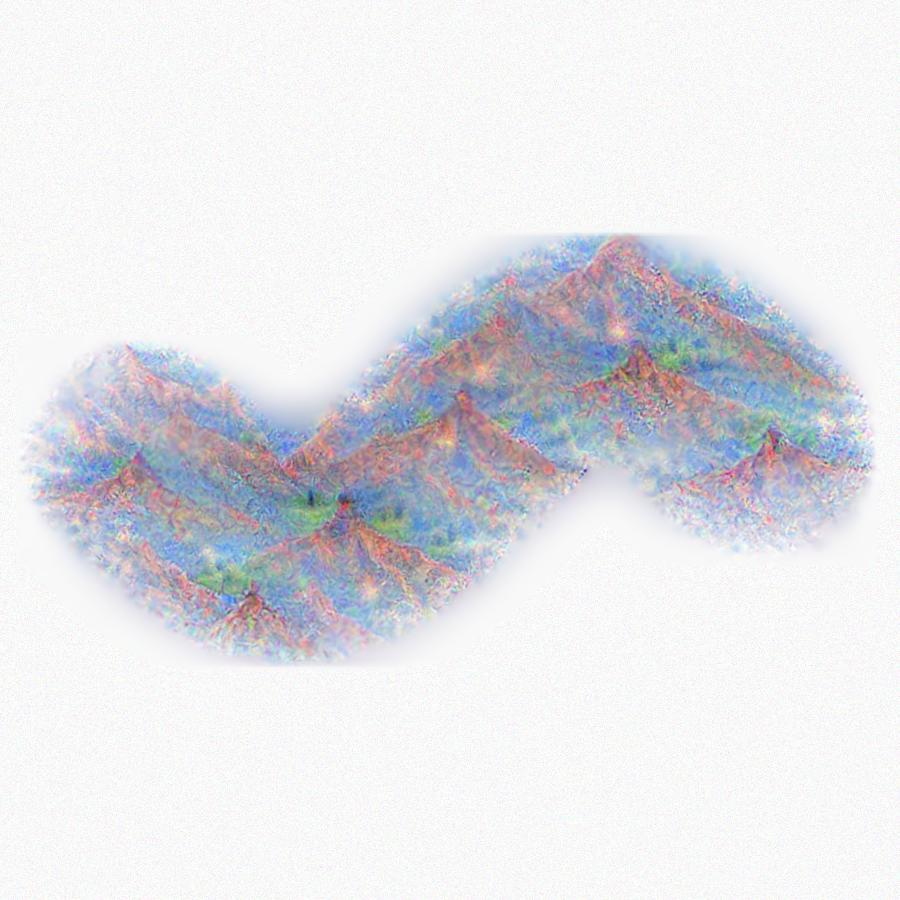

finished step 0 in octave 1
finished step 10 in octave 1
finished step 20 in octave 1
finished step 30 in octave 1
finished step 40 in octave 1
finished step 50 in octave 1
finished step 60 in octave 1
finished step 70 in octave 1
finished step 80 in octave 1
finished step 90 in octave 1
finished step 100 in octave 1
finished step 110 in octave 1
finished step 120 in octave 1
finished step 130 in octave 1
finished step 140 in octave 1
finished step 150 in octave 1
finished step 160 in octave 1
finished step 170 in octave 1
finished step 180 in octave 1
finished step 190 in octave 1
finished step 200 in octave 1
finished step 210 in octave 1
finished step 220 in octave 1
finished step 230 in octave 1
finished step 240 in octave 1
finished step 250 in octave 1
finished step 260 in octave 1
finished step 270 in octave 1
finished step 280 in octave 1
finished step 290 in octave 1
finished step 300 in octave 1
finished step 310 in octave 1
finished step 320 in octave 1
finished step 330 in 

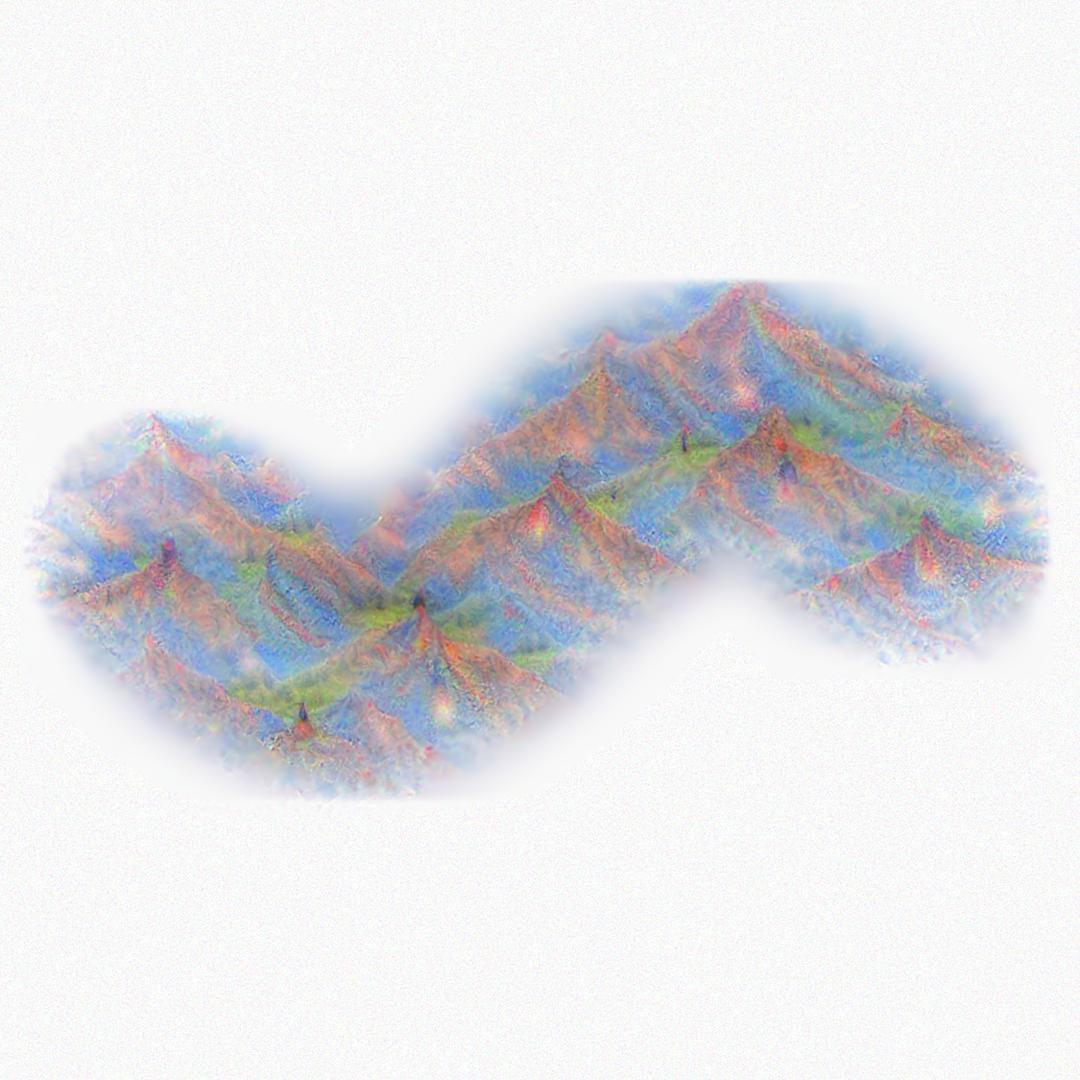

finished step 0 in octave 2
finished step 10 in octave 2
finished step 20 in octave 2
finished step 30 in octave 2
finished step 40 in octave 2
finished step 50 in octave 2
finished step 60 in octave 2
finished step 70 in octave 2
finished step 80 in octave 2
finished step 90 in octave 2
finished step 100 in octave 2
finished step 110 in octave 2
finished step 120 in octave 2
finished step 130 in octave 2
finished step 140 in octave 2
finished step 150 in octave 2
finished step 160 in octave 2
finished step 170 in octave 2
finished step 180 in octave 2
finished step 190 in octave 2
finished step 200 in octave 2
finished step 210 in octave 2
finished step 220 in octave 2
finished step 230 in octave 2
finished step 240 in octave 2
finished step 250 in octave 2
finished step 260 in octave 2
finished step 270 in octave 2
finished step 280 in octave 2
finished step 290 in octave 2
finished step 300 in octave 2
finished step 310 in octave 2
finished step 320 in octave 2
finished step 330 in 

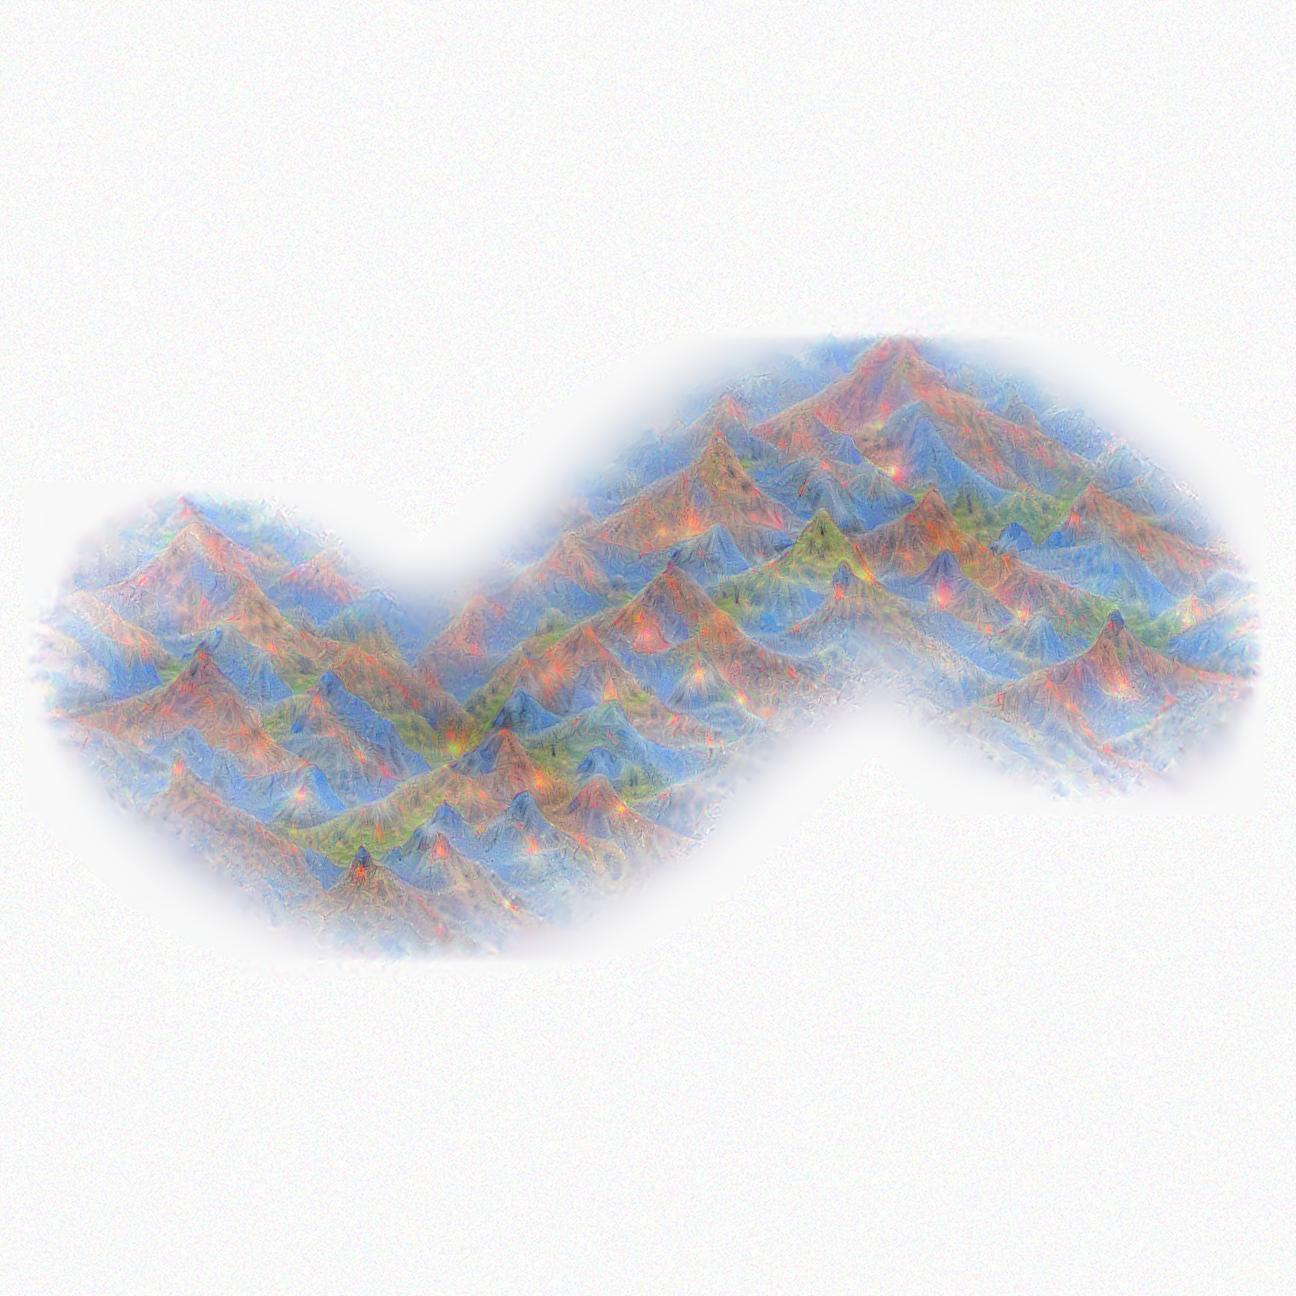

finished step 0 in octave 3
finished step 10 in octave 3
finished step 20 in octave 3
finished step 30 in octave 3
finished step 40 in octave 3
finished step 50 in octave 3
finished step 60 in octave 3
finished step 70 in octave 3
finished step 80 in octave 3
finished step 90 in octave 3
octave 3 image:


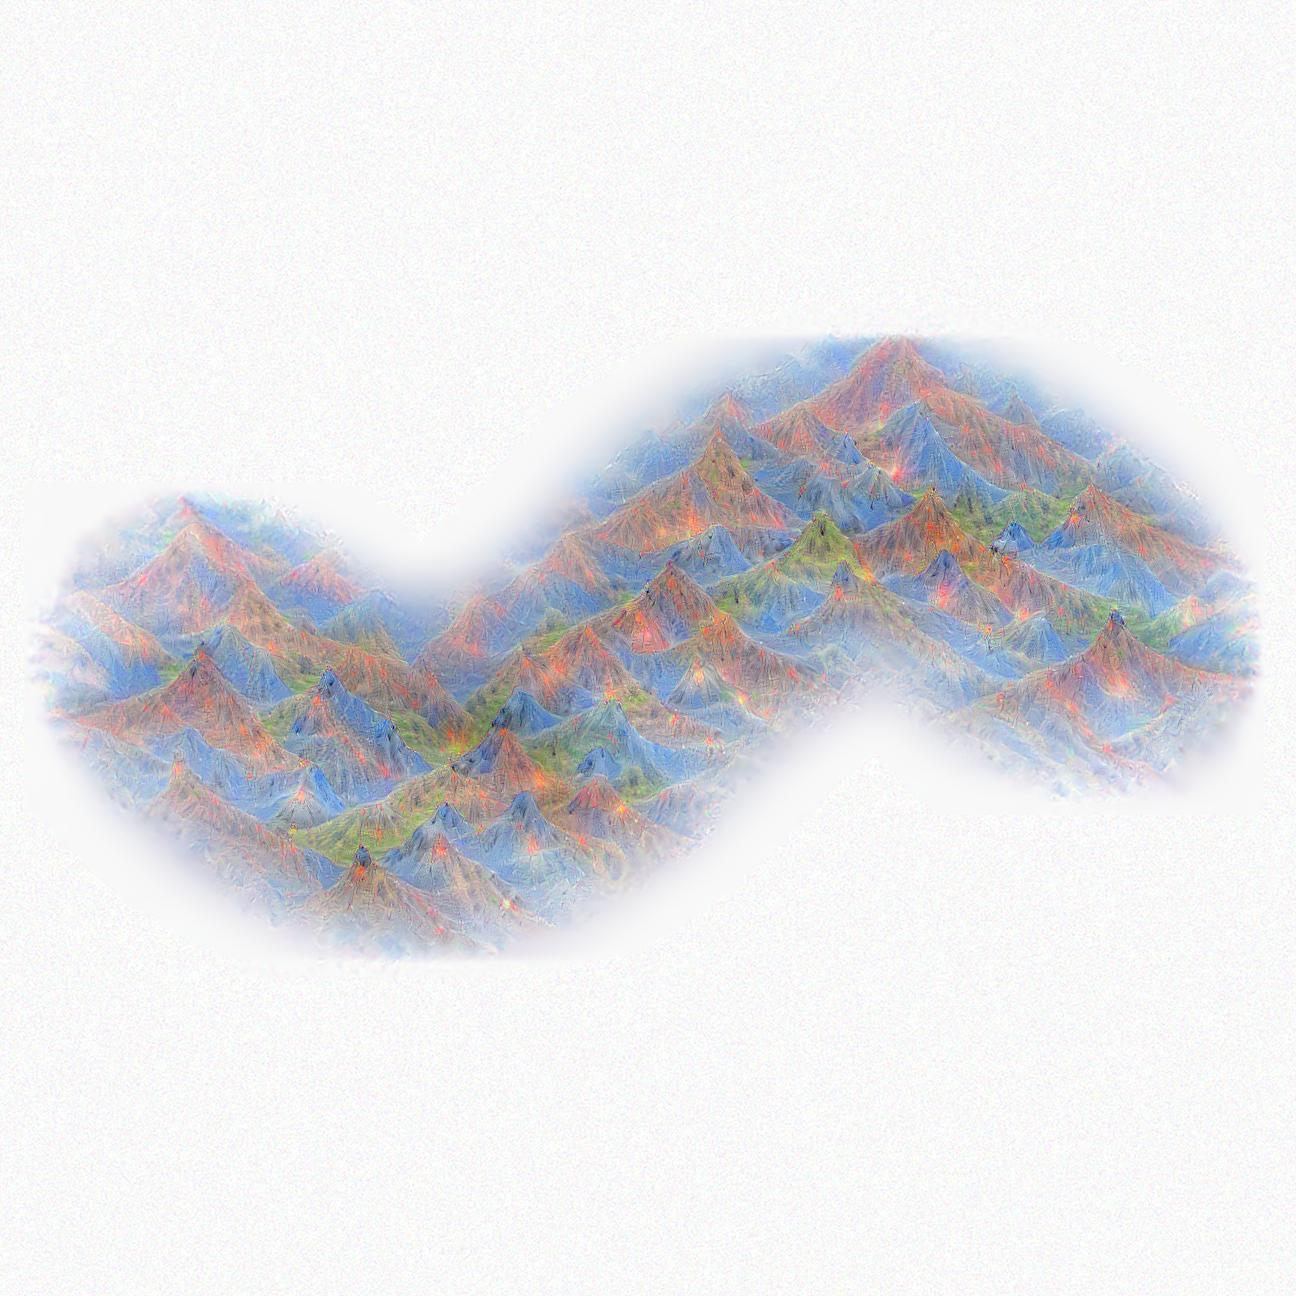

took seconds : 7678.259211


In [11]:
# simple generator for random sine path points
class SinePath:
    def __init__(self, x_start, x_end, y_origin, amplitude, cycles=1.):
        self.x_start = x_start
        self.x_end = x_end
        self.y_origin = y_origin
        self.amplitude = amplitude
        self.cycles = cycles
    def getPathPoint(self):
        rand_point = random.random()
        x_point = rand_point*(self.x_end-self.x_start) + self.x_start
        y_point = self.amplitude * math.sin(2*math.pi*rand_point*self.cycles) + self.y_origin
        return (y_point,x_point)

start_x = original_w/2. + 25
end_x = start_dim[0] - start_x
origin_y = start_dim[1]/2.
#amplitude = start_dim[1]-start_x
path = SinePath(start_x, end_x, origin_y, 100)

gen_image = np.random.normal(background_color, 8, (start_dim[0], start_dim[1], 3))

starttime = time.time()
gen_image = deepdraw(net, gen_image, octaves, focus, visualize=False, clip_gradient=clip_arr, pathfun=path)
print "took seconds : %f" % (time.time()-starttime)

# save image
#img_fn = '_'.join([model_name, "deepdraw_path", str(focus)+'.png'])
#PIL.Image.fromarray(np.uint8(gen_image)).save('./' + img_fn)

starting drawing
finished step 0 in octave 0
finished step 10 in octave 0
finished step 20 in octave 0
finished step 30 in octave 0
finished step 40 in octave 0
finished step 50 in octave 0
finished step 60 in octave 0
finished step 70 in octave 0
finished step 80 in octave 0
finished step 90 in octave 0
finished step 100 in octave 0
finished step 110 in octave 0
finished step 120 in octave 0
finished step 130 in octave 0
finished step 140 in octave 0
finished step 150 in octave 0
finished step 160 in octave 0
finished step 170 in octave 0
finished step 180 in octave 0
finished step 190 in octave 0
finished step 200 in octave 0
finished step 210 in octave 0
finished step 220 in octave 0
finished step 230 in octave 0
finished step 240 in octave 0
finished step 250 in octave 0
finished step 260 in octave 0
finished step 270 in octave 0
finished step 280 in octave 0
finished step 290 in octave 0
finished step 300 in octave 0
finished step 310 in octave 0
finished step 320 in octave 0
fini

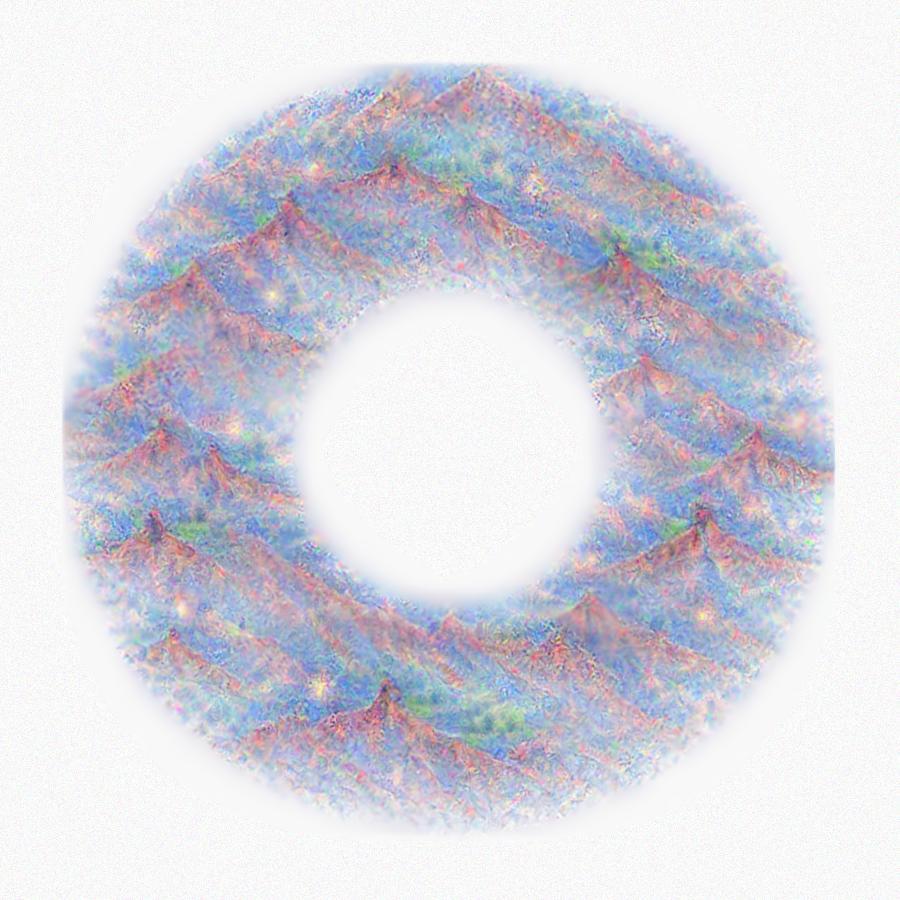

finished step 0 in octave 1
finished step 10 in octave 1
finished step 20 in octave 1
finished step 30 in octave 1
finished step 40 in octave 1
finished step 50 in octave 1
finished step 60 in octave 1
finished step 70 in octave 1
finished step 80 in octave 1
finished step 90 in octave 1
finished step 100 in octave 1
finished step 110 in octave 1
finished step 120 in octave 1
finished step 130 in octave 1
finished step 140 in octave 1
finished step 150 in octave 1
finished step 160 in octave 1
finished step 170 in octave 1
finished step 180 in octave 1
finished step 190 in octave 1
finished step 200 in octave 1
finished step 210 in octave 1
finished step 220 in octave 1
finished step 230 in octave 1
finished step 240 in octave 1
finished step 250 in octave 1
finished step 260 in octave 1
finished step 270 in octave 1
finished step 280 in octave 1
finished step 290 in octave 1
finished step 300 in octave 1
finished step 310 in octave 1
finished step 320 in octave 1
finished step 330 in 

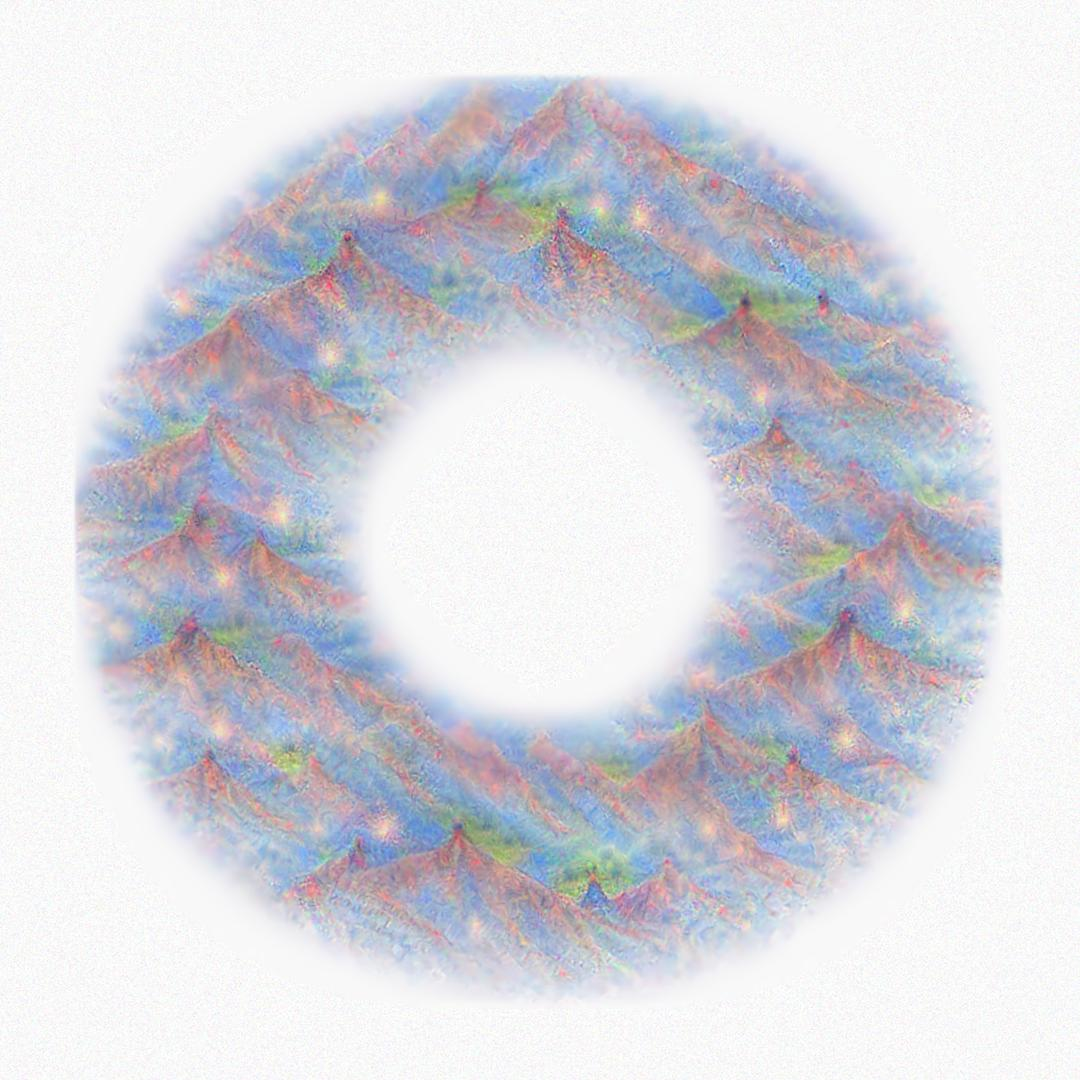

finished step 0 in octave 2
finished step 10 in octave 2
finished step 20 in octave 2
finished step 30 in octave 2
finished step 40 in octave 2
finished step 50 in octave 2
finished step 60 in octave 2
finished step 70 in octave 2
finished step 80 in octave 2
finished step 90 in octave 2
finished step 100 in octave 2
finished step 110 in octave 2
finished step 120 in octave 2
finished step 130 in octave 2
finished step 140 in octave 2
finished step 150 in octave 2
finished step 160 in octave 2
finished step 170 in octave 2
finished step 180 in octave 2
finished step 190 in octave 2
finished step 200 in octave 2
finished step 210 in octave 2
finished step 220 in octave 2
finished step 230 in octave 2
finished step 240 in octave 2
finished step 250 in octave 2
finished step 260 in octave 2
finished step 270 in octave 2
finished step 280 in octave 2
finished step 290 in octave 2
finished step 300 in octave 2
finished step 310 in octave 2
finished step 320 in octave 2
finished step 330 in 

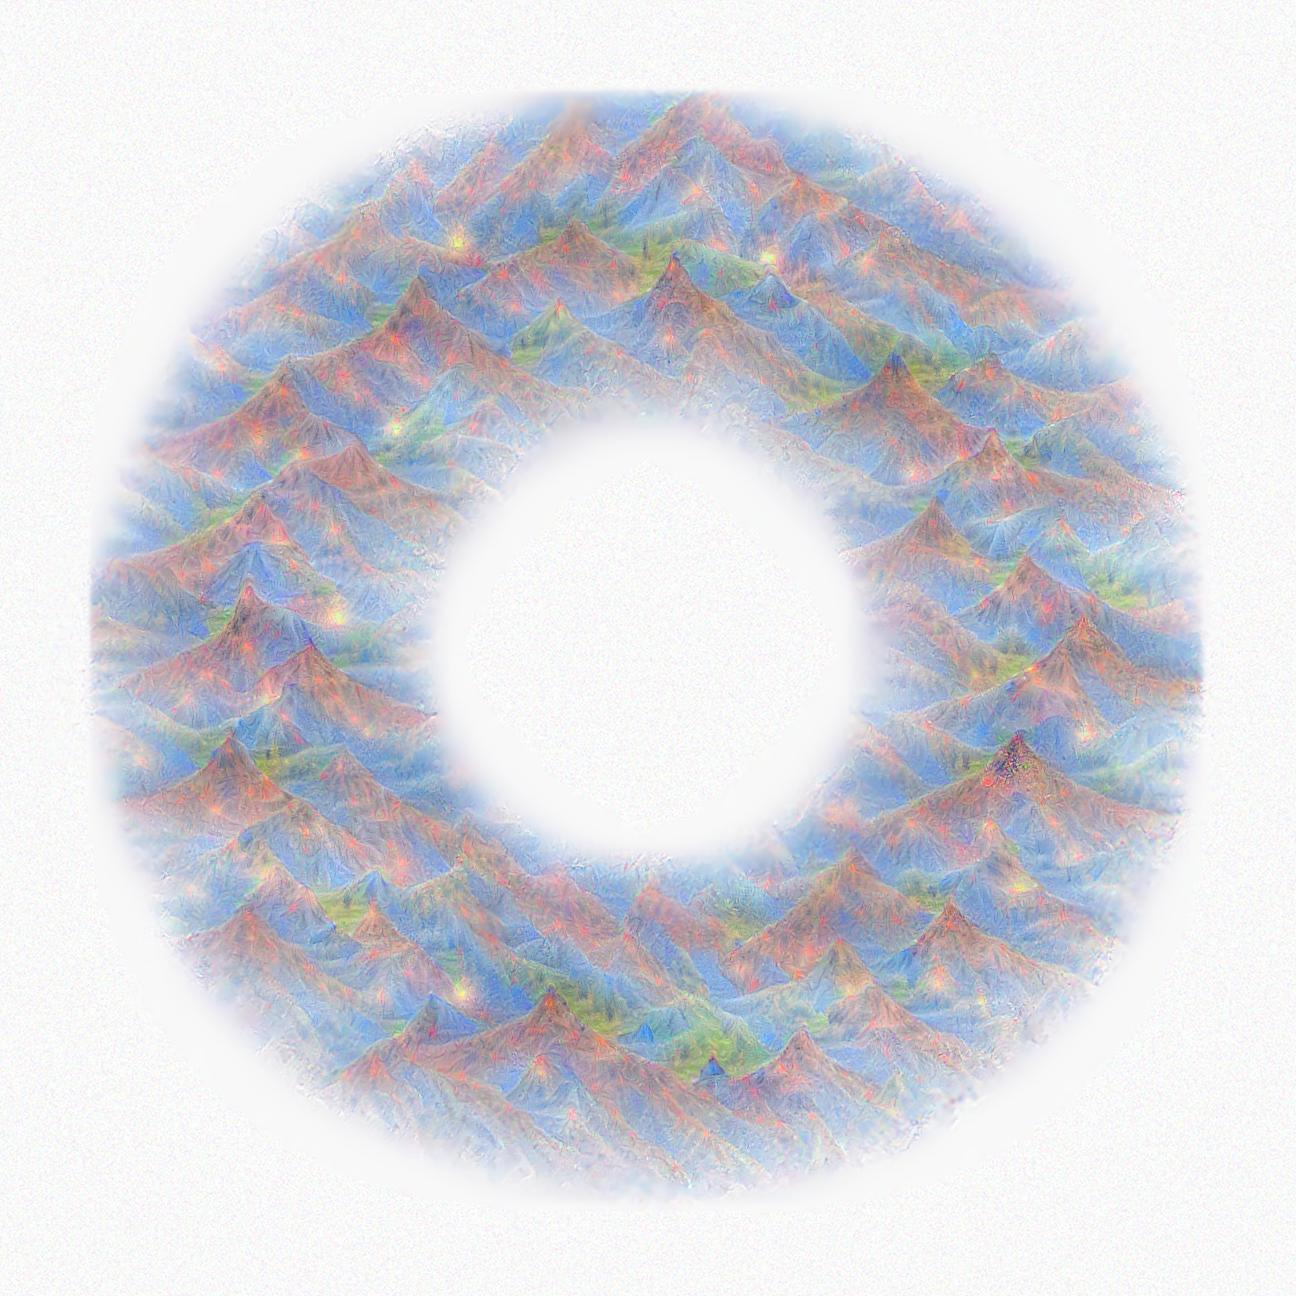

finished step 0 in octave 3
finished step 10 in octave 3
finished step 20 in octave 3
finished step 30 in octave 3
finished step 40 in octave 3
finished step 50 in octave 3
finished step 60 in octave 3
finished step 70 in octave 3
finished step 80 in octave 3
finished step 90 in octave 3
octave 3 image:


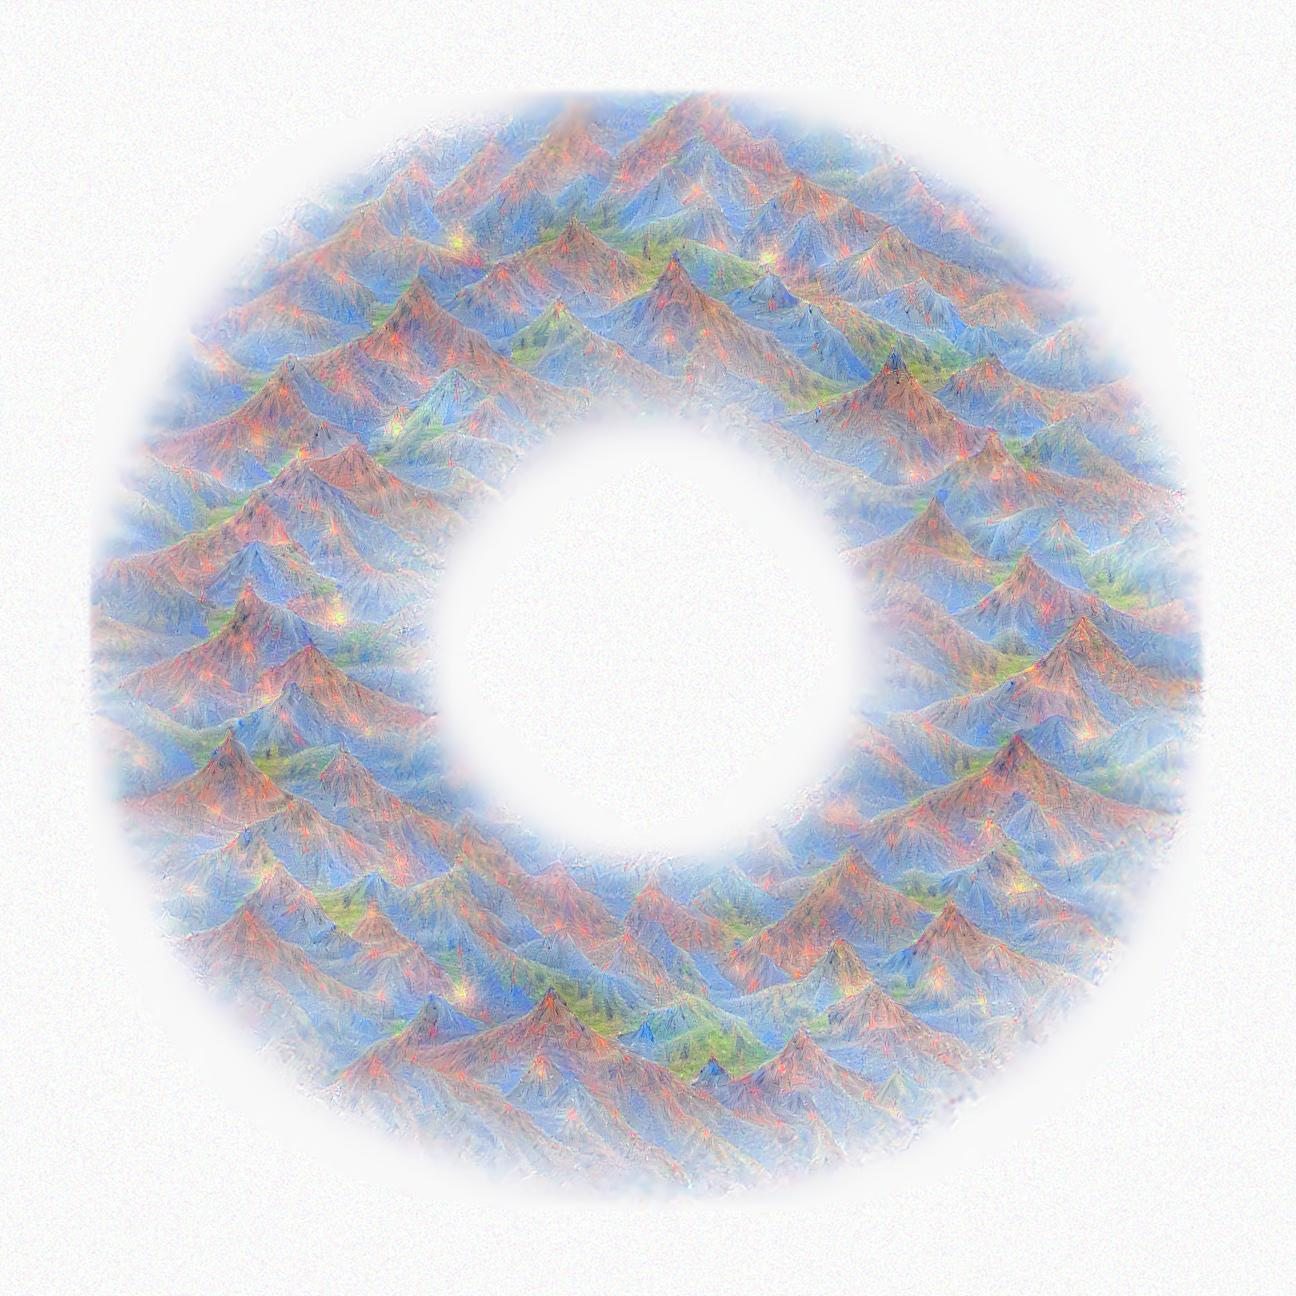

took seconds : 8005.564085


In [12]:
# simple generator for random circle path points
class CirclePath:
    def __init__(self, midpoint, radius):
        self.midpoint = midpoint
        self.radius = radius
    def getPathPoint(self):
        angle = random.random()*math.pi*2
        x = math.cos(angle)*self.radius + self.midpoint[0]
        y = math.sin(angle)*self.radius + self.midpoint[1]
        return (y,x)

mid = [start_dim[0]/2., start_dim[1]/2.]
path = CirclePath(mid, start_dim[0]*0.3)

gen_image = np.random.normal(background_color, 8, (start_dim[0], start_dim[1], 3))

starttime = time.time()
gen_image = deepdraw(net, gen_image, octaves, focus, visualize=False, clip_gradient=clip_arr, pathfun=path)
print "took seconds : %f" % (time.time()-starttime)

# save image
#img_fn = '_'.join([model_name, "deepdraw_path", str(focus)+'.png'])
#PIL.Image.fromarray(np.uint8(gen_image)).save('./' + img_fn)

starting drawing
finished step 10 in octave 0
finished step 20 in octave 0
finished step 30 in octave 0
finished step 40 in octave 0
finished step 50 in octave 0
finished step 60 in octave 0
finished step 70 in octave 0
finished step 80 in octave 0
finished step 90 in octave 0
finished step 100 in octave 0
finished step 110 in octave 0
finished step 120 in octave 0
finished step 130 in octave 0
finished step 140 in octave 0
finished step 150 in octave 0
finished step 160 in octave 0
finished step 170 in octave 0
finished step 180 in octave 0
finished step 190 in octave 0
finished step 200 in octave 0
finished step 210 in octave 0
finished step 220 in octave 0
finished step 230 in octave 0
finished step 240 in octave 0
finished step 250 in octave 0
finished step 260 in octave 0
finished step 270 in octave 0
finished step 280 in octave 0
finished step 290 in octave 0
finished step 300 in octave 0
finished step 310 in octave 0
finished step 320 in octave 0
finished step 330 in octave 0
fi

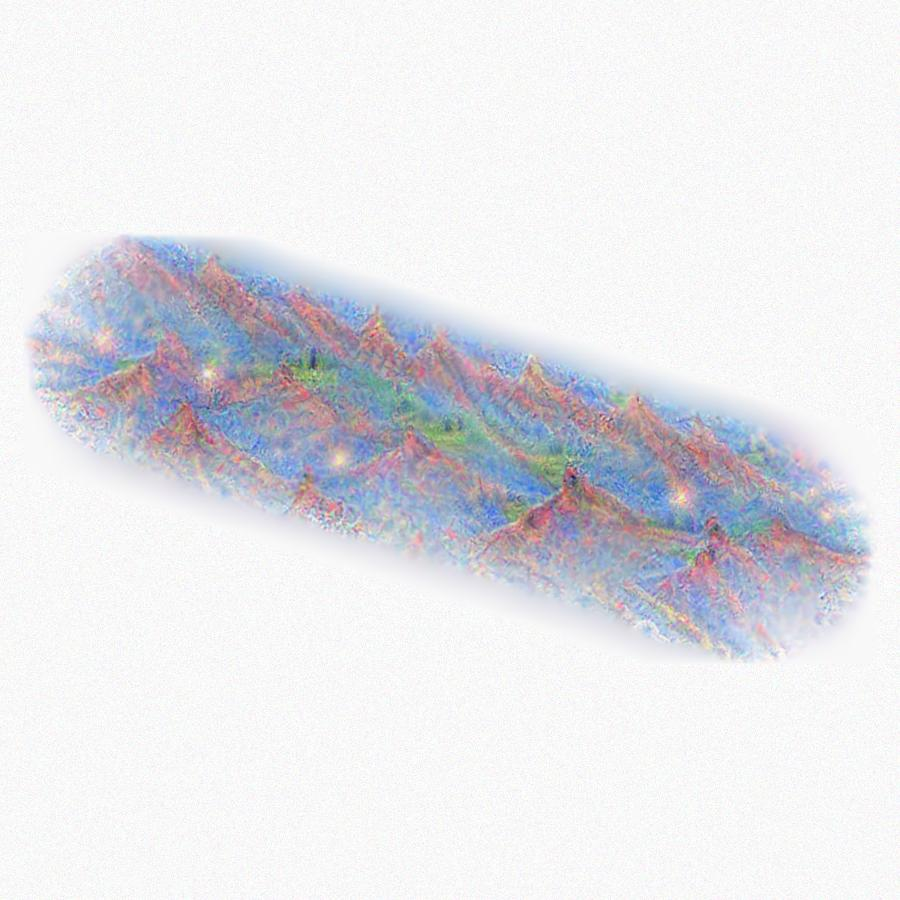

finished step 10 in octave 1
finished step 20 in octave 1
finished step 30 in octave 1
finished step 40 in octave 1
finished step 50 in octave 1
finished step 60 in octave 1
finished step 70 in octave 1
finished step 80 in octave 1
finished step 90 in octave 1
finished step 100 in octave 1
finished step 110 in octave 1
finished step 120 in octave 1
finished step 130 in octave 1
finished step 140 in octave 1
finished step 150 in octave 1
finished step 160 in octave 1
finished step 170 in octave 1
finished step 180 in octave 1
finished step 190 in octave 1
finished step 200 in octave 1
finished step 210 in octave 1
finished step 220 in octave 1
finished step 230 in octave 1
finished step 240 in octave 1
finished step 250 in octave 1
finished step 260 in octave 1
finished step 270 in octave 1
finished step 280 in octave 1
finished step 290 in octave 1
finished step 300 in octave 1
finished step 310 in octave 1
finished step 320 in octave 1
finished step 330 in octave 1
finished step 340 i

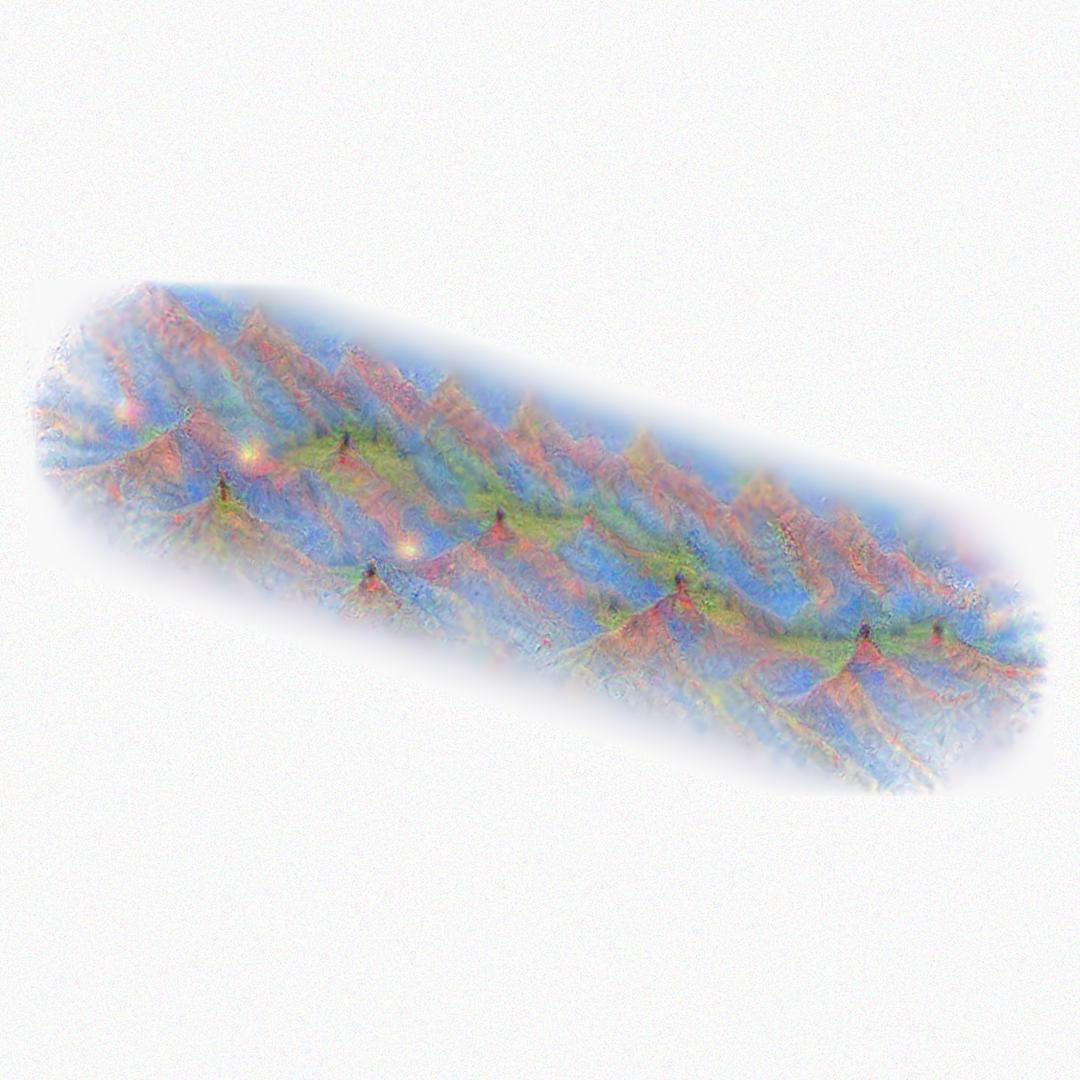

finished step 10 in octave 2
finished step 20 in octave 2
finished step 30 in octave 2
finished step 40 in octave 2
finished step 50 in octave 2
finished step 60 in octave 2
finished step 70 in octave 2
finished step 80 in octave 2
finished step 90 in octave 2
finished step 100 in octave 2
finished step 110 in octave 2
finished step 120 in octave 2
finished step 130 in octave 2
finished step 140 in octave 2
finished step 150 in octave 2
finished step 160 in octave 2
finished step 170 in octave 2
finished step 180 in octave 2
finished step 190 in octave 2
finished step 200 in octave 2
finished step 210 in octave 2
finished step 220 in octave 2
finished step 230 in octave 2
finished step 240 in octave 2
finished step 250 in octave 2
finished step 260 in octave 2
finished step 270 in octave 2
finished step 280 in octave 2
finished step 290 in octave 2
finished step 300 in octave 2
finished step 310 in octave 2
finished step 320 in octave 2
finished step 330 in octave 2
finished step 340 i

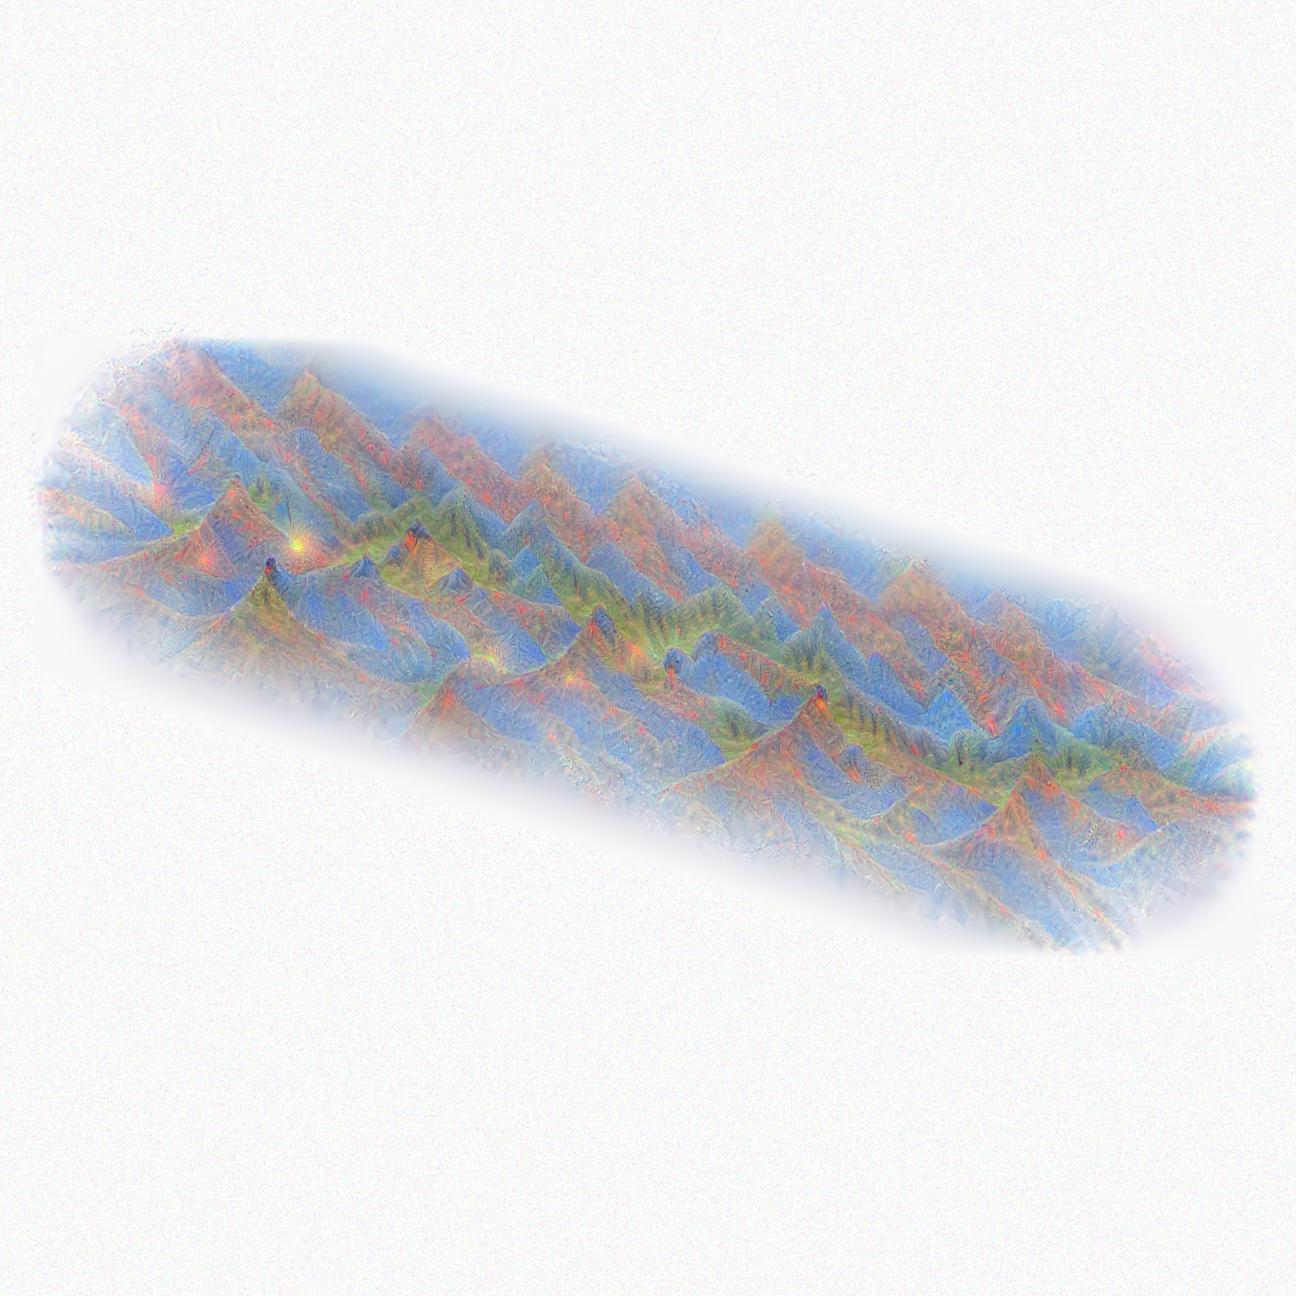

finished step 10 in octave 3
finished step 20 in octave 3
finished step 30 in octave 3
finished step 40 in octave 3
finished step 50 in octave 3
finished step 60 in octave 3
finished step 70 in octave 3
finished step 80 in octave 3
finished step 90 in octave 3
octave 3 image:


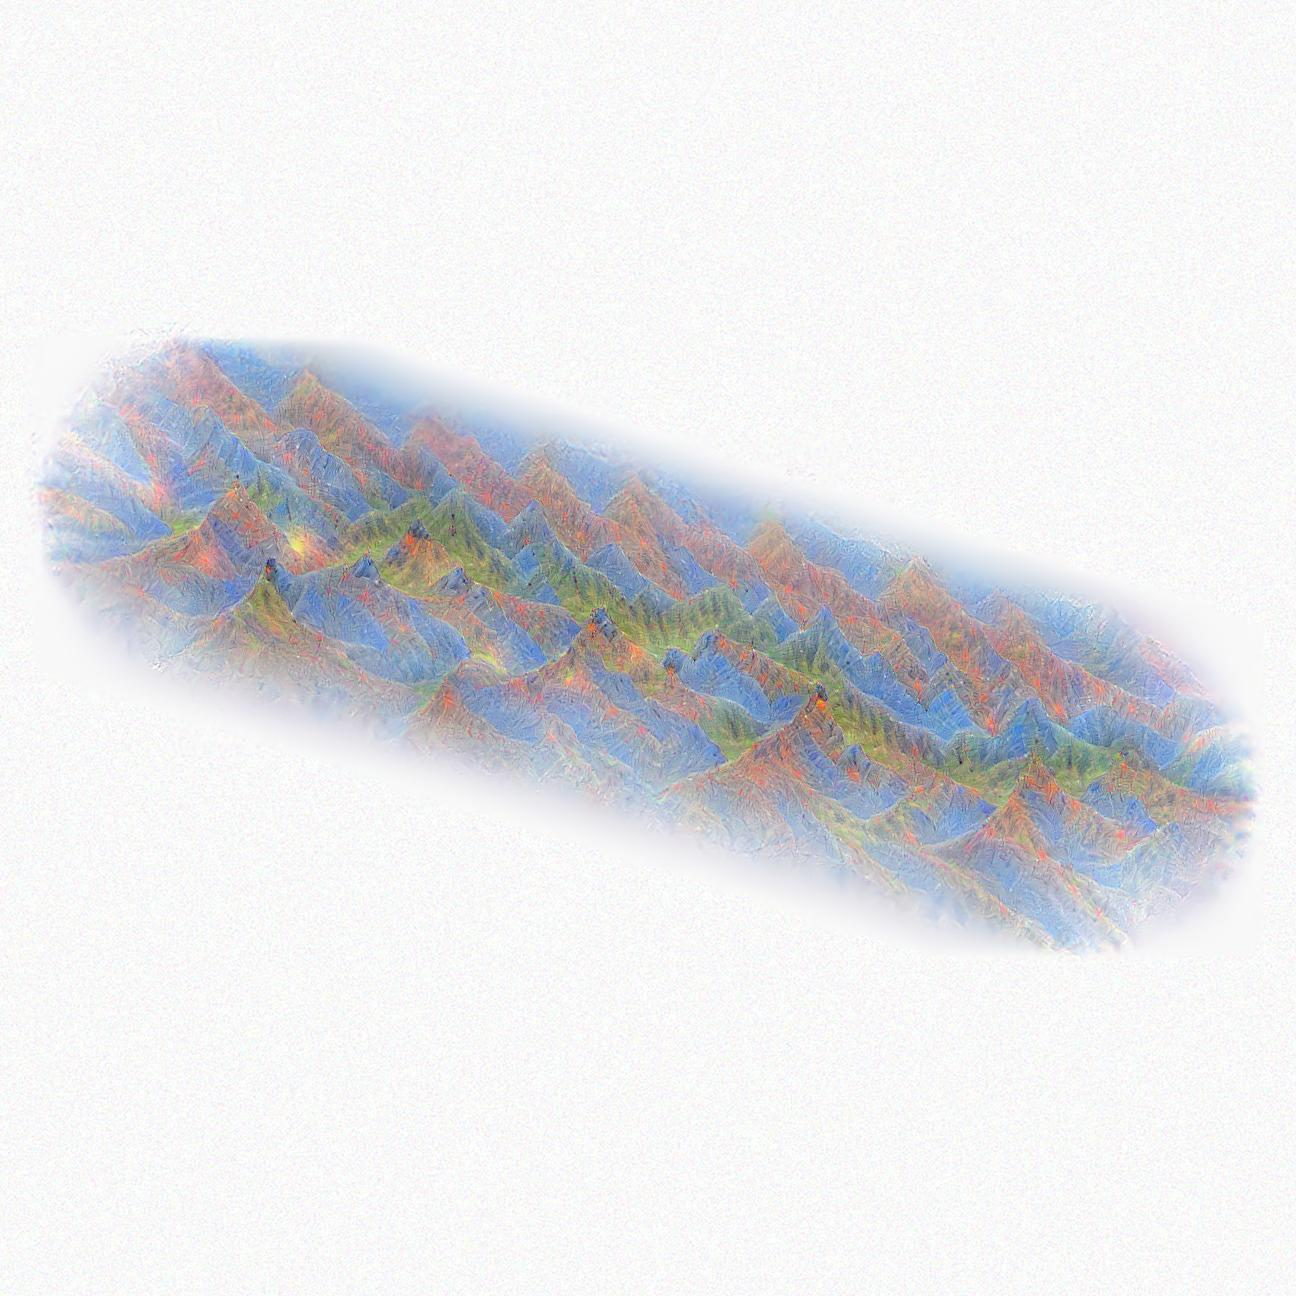

took seconds : 7489.063035


In [6]:
# simple generator for random straight path points
class StraightPath:
    def __init__(self, start, end):
        self.start = start
        self.end = end
    def getPathPoint(self):
        randpoint = random.random()
        x = start[0] + randpoint*(end[0]-start[0])
        y = start[1] + randpoint*(end[1]-start[1])
        return (y,x)

start = [original_w/2. + 25,start_dim[1]/2. - 100]
end = [start_dim[0]-original_w/2.-25,start_dim[1]/2. + 100]
path = StraightPath(start,end)

gen_image = np.random.normal(background_color, 8, (start_dim[0], start_dim[1], 3))

starttime = time.time()
gen_image = deepdraw(net, gen_image, octaves, focus, visualize=False, clip_gradient=clip_arr, pathfun=path)
print "took seconds : %f" % (time.time()-starttime)

# save image
#img_fn = '_'.join([model_name, "deepdraw_path", str(focus)+'.png'])
#PIL.Image.fromarray(np.uint8(gen_image)).save('./' + img_fn)